<a href="https://colab.research.google.com/github/AnyueWang/ExerciseProjects/blob/main/transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning - Fine Tuning



In [2]:
!nvidia-smi

Tue Jan  3 14:56:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-03 14:56:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-03 14:56:43 (111 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-01-03 14:56:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.128, 142.251.167.128, 142.250.188.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   157MB/s    in 1.0s    

2023-01-03 14:56:47 (157 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [7]:
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [8]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.48724489e+01 1.48724489e+01 4.87244892e+00]
   [1.30714283e+01 1.30714283e+01 3.07142854e+00]
   [1.40000000e+01 1.55714283e+01 4.78571415e+00]
   ...
   [1.20663147e+01 1.72806091e+01 1.17091980e+01]
   [6.29072809e+00 1.32856445e+01 8.95400620e+00]
   [1.33417645e+01 2.36274700e+01 1.79846172e+01]]

  [[1.43775501e+01 1.43775501e+01 4.37755108e+00]
   [1.40000000e+01 1.60000000e+01 5.00000000e+00]
   [1.57142859e+01 1.77142849e+01 6.71428585e+00]
   ...
   [7.98468399e+00 1.31989784e+01 7.62756729e+00]
   [6.14794016e+00 1.21479406e+01 8.14794064e+00]
   [1.68111382e+01 2.58111382e+01 2.08111382e+01]]

  [[1.63571434e+01 1.67857151e+01 6.57142878e+00]
   [1.72142868e+01 1.92142868e+01 8.21428585e+00]
   [1.60918369e+01 1.82602043e+01 7.59693909e+00]
   ...
   [6.21427727e+00 1.14285717e+01 5.85716057e+00]
   [4.30099916e+00 1.03009996e+01 6.30099916e+00]
   [1.68570557e+01 2.58570557e+01 2.08570557e+01]]

  ...

  [[1.19928551e+02 1.40142807e+02 8.11428146e+01]
   [1

In [12]:
# model 0 (functional API provides more flexibility)

# 1. create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. freeze the base model 
base_model.trainable = False

# 3. create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# 4. normalize inputs (no need for efficient networks)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. pass the inputs to the base_model
x = base_model(inputs)
print(f'shape after passing inputs through base model: {x.shape}')

# 6. average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'shape after GlobalAveragePooling2D: {x.shape}')

# 7. create the output activation layer
outputs = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

# 8. combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. compile the model
model_0.compile(loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])

# 10. fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
             epochs=5,
             steps_per_epoch=len(train_data_10_percent),
             validation_data=test_data,
             validation_steps=int(0.25*len(test_data)),
             callbacks=[create_tensorboard_callback(dir_name='transfer_learning',experiment_name='10_percent_feature_extraction')])


16705208/16705208 [==============================] - 0s 0us/step
shape after passing inputs through base model: (None, 7, 7, 1280)
shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230103-145655
Epoch 1/5
24/24 [==============================] - 18s 227ms/step - loss: 1.8586 - accuracy: 0.4320 - val_loss: 1.2658 - val_accuracy: 0.7500
Epoch 2/5
24/24 [==============================] - 4s 157ms/step - loss: 1.0765 - accuracy: 0.7627 - val_loss: 0.8514 - val_accuracy: 0.8355
Epoch 3/5
24/24 [==============================] - 5s 185ms/step - loss: 0.7757 - accuracy: 0.8280 - val_loss: 0.6666 - val_accuracy: 0.8470
Epoch 4/5
24/24 [==============================] - 5s 185ms/step - loss: 0.6319 - accuracy: 0.8627 - val_loss: 0.5655 - val_accuracy: 0.8783
Epoch 5/5
24/24 [==============================] - 5s 186ms/step - loss: 0.5415 - accuracy: 0.8773 - val_loss: 0.5460 - val_accuracy: 0.8586


In [13]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.5524 - accuracy: 0.8688


[0.5524286031723022, 0.8687999844551086]

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [15]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [16]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

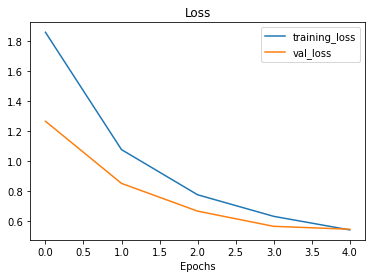

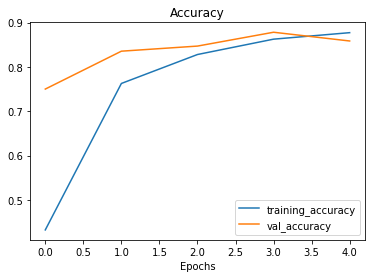

In [17]:
plot_loss_curves(history_0)

## Getting a feature vector from the trained model


In [18]:
input_shape = (1,4,4,3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'random input tensor:\n {input_tensor}\n')

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor}')

random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]


In [19]:
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a seriese of transfer learning experiments

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the tranining data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

In [20]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data('10_food_classes_1_percent.zip')

--2023-01-03 14:57:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   261MB/s    in 0.5s    

2023-01-03 14:57:53 (261 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [22]:
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

In [23]:
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                       label_mode='categorical',
                                       image_size=IMG_SIZE,
                                       batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                 label_mode='categorical',
                                 image_size=IMG_SIZE,
                                 batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The benefits of using data augmentation inside the model are：
- preprocessing of images (augmenting them) happens on the GPU rather than the CPU
- image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255),
], name='data_augmentation')

(-0.5, 598.5, 520.5, -0.5)

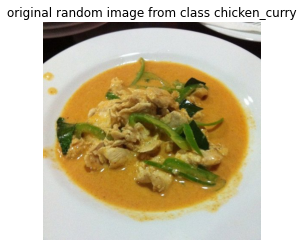

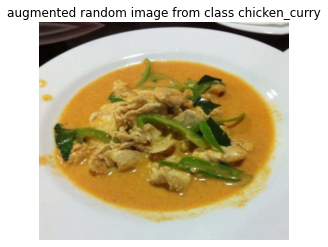

In [25]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'original random image from class {target_class}')
plt.axis(False)

augmented_img = data_augmentation(tf.expand_dims(img,axis=0),training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255)
plt.title(f'augmented random image from class {target_class}')
plt.axis(False)

In [26]:
target_class

'chicken_curry'

In [27]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# add in data augmentation Sequential model as a layer
x = data_augmentation(inputs, training=True)

# give base_model the inputs and don't train it
x = base_model(x, training=False)

# pool output features of the base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x) # layer

# put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# compile the model
model_1.compile(loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_1_percent),
                 validation_data=test_data,
                 validation_steps=int(0.25*len(test_data)),
                 callbacks=[create_tensorboard_callback(dir_name='transfer_learning',experiment_name='1_percent_data_aug')])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230103-145758
Epoch 1/5
3/3 [==============================] - 17s 5s/step - loss: 2.4633 - accuracy: 0.0714 - val_loss: 2.2501 - val_accuracy: 0.1875
Epoch 2/5
3/3 [==============================] - 11s 5s/step - loss: 2.1854 - accuracy: 0.2429 - val_loss: 2.0981 - val_accuracy: 0.2664
Epoch 3/5
3/3 [==============================] - 8s 4s/step - loss: 1.9561 - accuracy: 0.4857 - val_loss: 2.0071 - val_accuracy: 0.3257
Epoch 4/5
3/3 [==============================] - 11s 5s/step - loss: 1.7783 - accuracy: 0.5571 - val_loss: 1.9198 - val_accuracy: 0.3734
Epoch 5/5
3/3 [==============================] - 11s 5s/step - loss: 1.6569 - accuracy: 0.6571 - val_loss: 1.8018 - val_accuracy: 0.4326


In [28]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 22s 275ms/step - loss: 1.8280 - accuracy: 0.4412


[1.8279898166656494, 0.44119998812675476]

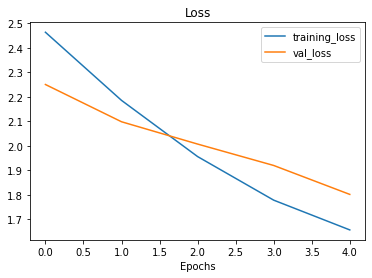

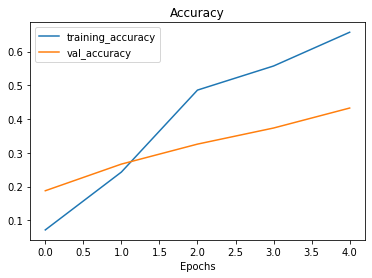

In [29]:
plot_loss_curves(history_1_percent)

In [30]:
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [31]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                       label_mode='categorical',
                                       image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                 label_mode='categorical',
                                 image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, None, None, 3)     0         
                                                                 
 random_rotation (RandomRota  (None, None, None, 3)    0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, None, None, 3)     0         
                                                                 
 random_height (RandomHeight  (None, None, None, 3)    0         
 )                                                               
                                                                 
 random_width (RandomWidth)  (None, None, None, 3)     0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable

In [33]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
], name='data_augmentation')



In [34]:
input_shape = (224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs,training=True)
x = base_model(x,training=False)# training=flase, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs = layers.Dense(10,activation='softmax',name='output_layer')(x)
model_2 = tf.keras.Model(inputs,outputs)

model_2.compile(loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])


In [35]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [36]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [37]:
tf.keras.callbacks.ModelCheckpoint

keras.callbacks.ModelCheckpoint

## Create a modelcheckpoint callback

In [38]:
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

# create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=False,
                              save_freq='epoch',#save every epoch
                              verbose=1)


In [39]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                      epochs=initial_epochs,
                      validation_data=test_data,
                      validation_steps=int(0.25*len(test_data)),
                      callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                          experiment_name='10_percent_data_aug'),
                            checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230103-145953
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9651 - accuracy: 0.3760
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 20s 607ms/step - loss: 1.9651 - accuracy: 0.3760 - val_loss: 1.5343 - val_accuracy: 0.6316
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2967 - accuracy: 0.7160
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 449ms/step - loss: 1.2967 - accuracy: 0.7160 - val_loss: 1.1200 - val_accuracy: 0.7286
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9650 - accuracy: 0.7853
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 708ms/step - loss: 0.9650 - accuracy: 0.7853 - val_loss: 0.9114 - val_accuracy: 0.7664
E

In [40]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 74ms/step - loss: 0.5524 - accuracy: 0.8688


[0.5524287819862366, 0.8687999844551086]

In [41]:
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 18s 219ms/step - loss: 0.7590 - accuracy: 0.7956


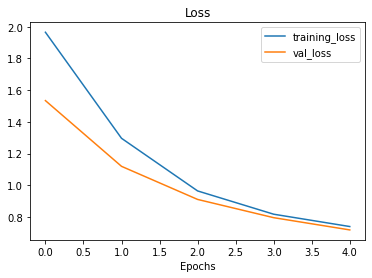

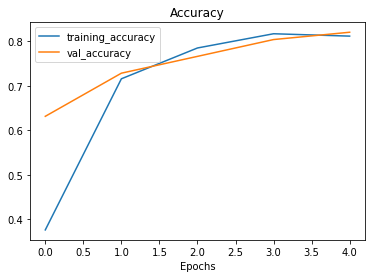

In [42]:
plot_loss_curves(history_10_percent_data_aug)

### loading in checkpointed weights



In [43]:
model_2.load_weights(checkpoint_path)

In [44]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 18s 218ms/step - loss: 0.7444 - accuracy: 0.7996


In [45]:
results_10_percent_data_aug

[0.759040355682373, 0.7955999970436096]

In [46]:
loaded_weights_model_results

[0.7444411516189575, 0.7996000051498413]

In [47]:
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([False, False])

## Model 3: Fine-tuning an existing model on 10% of the data

Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

In [48]:
model_2.layers

In [49]:
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa87bf6eee0> True
<keras.engine.sequential.Sequential object at 0x7fa87bf0d6a0> True
<keras.engine.functional.Functional object at 0x7fa87bd6ac70> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fa87bf25ac0> True
<keras.layers.core.dense.Dense object at 0x7fa87bf0d550> True


In [51]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [52]:
print(len(model_2.layers[2].trainable_variables))

0


In [55]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable=False

# recompile
model_2.compile(loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate need to be small since the model is already be well-trained, we don't want to change the model that much (in case of overfitting)
        metrics=['accuracy'])



In [56]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [57]:
print(len(model_2.trainable_variables))

12


In [58]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                         epochs=fine_tune_epochs,
                         validation_data=test_data,
                         validation_steps=int(0.25*len(test_data)),
                         initial_epoch=history_10_percent_data_aug.epoch[-1],
                         callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                             experiment_name='10_percent_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230103-154200
Epoch 5/10
24/24 [==============================] - 20s 542ms/step - loss: 0.6206 - accuracy: 0.8293 - val_loss: 0.5779 - val_accuracy: 0.8207
Epoch 6/10
24/24 [==============================] - 11s 451ms/step - loss: 0.4848 - accuracy: 0.8507 - val_loss: 0.5678 - val_accuracy: 0.8174
Epoch 7/10
24/24 [==============================] - 10s 419ms/step - loss: 0.4341 - accuracy: 0.8667 - val_loss: 0.5518 - val_accuracy: 0.8043
Epoch 8/10
24/24 [==============================] - 9s 377ms/step - loss: 0.3999 - accuracy: 0.8693 - val_loss: 0.5072 - val_accuracy: 0.8405
Epoch 9/10
24/24 [==============================] - 10s 419ms/step - loss: 0.3554 - accuracy: 0.8947 - val_loss: 0.5049 - val_accuracy: 0.8322
Epoch 10/10
24/24 [==============================] - 9s 361ms/step - loss: 0.3326 - accuracy: 0.9067 - val_loss: 0.5205 - val_accuracy: 0.8240


In [59]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 17s 207ms/step - loss: 0.5337 - accuracy: 0.8248


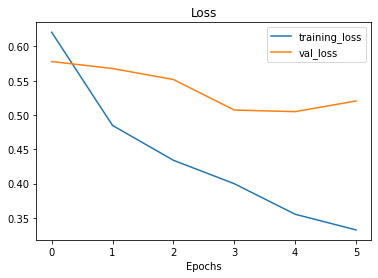

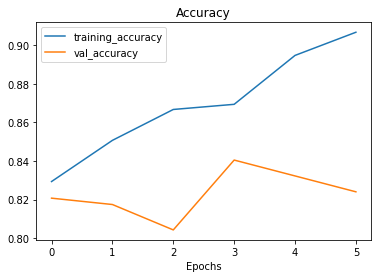

In [61]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [66]:
def compare_historys(original_history,new_history,initial_epochs=5):
  '''
  compares two TensorFlow history object
  '''
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label='training accuracy')
  plt.plot(total_val_acc, label='val accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='start fine tuning')
  plt.legend(loc='lower right')
  plt.title('training and validation accuracy')

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label='training loss')
  plt.plot(total_val_loss, label='val loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='start fine tuning')
  plt.legend(loc='upper right')
  plt.title('training and validation loss')

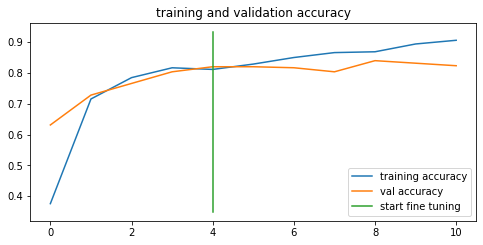

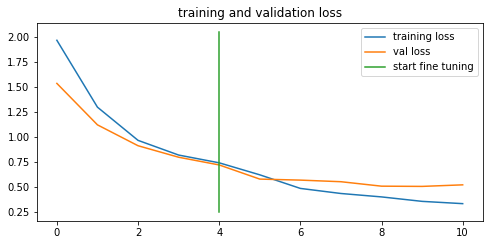

In [67]:
compare_historys(history_10_percent_data_aug,history_fine_10_percent_data_aug,initial_epochs=5)

## Model 4: Fine-tuning an existing model on 100% of the data

In [68]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data('10_food_classes_all_data.zip')

--2023-01-03 16:00:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   241MB/s    in 2.1s    

2023-01-03 16:00:18 (241 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [72]:
train_dir_all_data = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [70]:
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

In [73]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                          label_mode='categorical',
                                          image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                 label_mode='categorical',
                                 image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [74]:
model_2.evaluate(test_data)

79/79 [==============================] - 16s 188ms/step - loss: 0.5342 - accuracy: 0.8248


[0.5342138409614563, 0.8248000144958496]

In [75]:
results_fine_tune_10_percent

[0.5337148904800415, 0.8248000144958496]

In [76]:
model_2.load_weights(checkpoint_path)

In [77]:
model_2.evaluate(test_data)

79/79 [==============================] - 16s 183ms/step - loss: 0.7552 - accuracy: 0.7988


[0.7552445530891418, 0.798799991607666]

In [78]:
results_10_percent_data_aug

[0.759040355682373, 0.7955999970436096]

In [79]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [80]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [81]:
model_2.compile(loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy'])

In [83]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                       epochs=fine_tune_epochs,
                       validation_data=test_data,
                       validation_steps=int(0.25*len(test_data)),
                       initial_epoch=history_10_percent_data_aug.epoch[-1],
                       callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                           experiment_name='full_10_classes_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230103-162858
Epoch 5/10
235/235 [==============================] - 56s 212ms/step - loss: 0.6541 - accuracy: 0.7920 - val_loss: 0.4491 - val_accuracy: 0.8503
Epoch 6/10
235/235 [==============================] - 46s 193ms/step - loss: 0.5311 - accuracy: 0.8275 - val_loss: 0.3973 - val_accuracy: 0.8849
Epoch 7/10
235/235 [==============================] - 46s 194ms/step - loss: 0.4690 - accuracy: 0.8489 - val_loss: 0.4255 - val_accuracy: 0.8651
Epoch 8/10
235/235 [==============================] - 43s 178ms/step - loss: 0.4175 - accuracy: 0.8645 - val_loss: 0.3966 - val_accuracy: 0.8816
Epoch 9/10
235/235 [==============================] - 49s 208ms/step - loss: 0.3866 - accuracy: 0.8745 - val_loss: 0.3974 - val_accuracy: 0.8898
Epoch 10/10
235/235 [==============================] - 46s 196ms/step - loss: 0.3592 - accuracy: 0.8843 - val_loss: 0.3965 - val_accuracy: 0.8898


In [84]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 12s 146ms/step - loss: 0.3470 - accuracy: 0.8880


[0.34700897336006165, 0.8880000114440918]

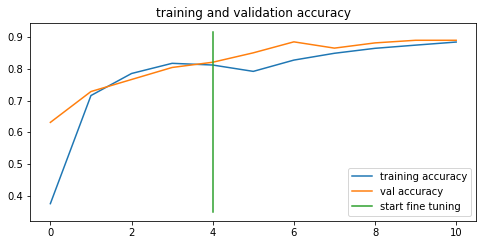

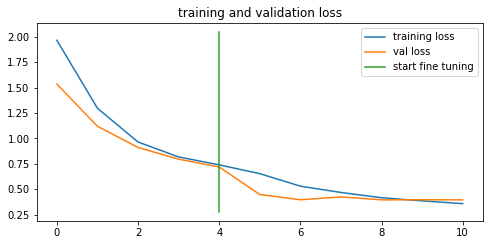

In [85]:
compare_historys(history_10_percent_data_aug,
         history_fine_10_classes_full,
         initial_epochs=5)

In [87]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name 'Transfer Learning Experiments with 10 Food101 Classes'\
  --description 'A series of different transfer learning experiments with varying amounts of data and fune-tuning.' \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=iTpE34zK7pPJFPVfIzpCYlcV1VpbPU&prompt=consent&access_type=o

In [89]:
!tensorboard dev list


https://tensorboard.dev/experiment/8yv3xrKmRXaLB6dUlEiaqw/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fune-tuning.
	Id                   8yv3xrKmRXaLB6dUlEiaqw
	Created              2023-01-03 16:41:25 (6 minutes ago)
	Updated              2023-01-03 16:41:30 (6 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4361903
https://tensorboard.dev/experiment/eUpE8WvNROuomkTlipwRJw/
	Name                 EfficientNet vs. ResNet
	Description          Comparing two different TF Hub feature extraction model architecture
	Id                   eUpE8WvNROuomkTlipwRJw
	Created              2022-12-24 10:38:02
	Updated              2022-12-24 10:38:07
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3140503
Tot